# 프로젝트: 자율주행 보조 시스템 만들기

## 1. 자율주행 시스템 만들기
위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

입력으로 이미지 경로를 받습니다.
정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
조건은 다음과 같습니다.
사람이 한 명 이상 있는 경우
차량의 크기(width or height)가 300px이상인 경우

## 평가 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항	상세기준
1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다. : KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다.
2. RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다. : 바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다.
3. 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다. : 테스트 수행결과 90% 이상의 정확도를 보였다.

# 자율주행 보조장치 (1) KITTI 데이터셋

이번 시간에 만들어 볼 자율주행 보조장치는 카메라에 사람이 가까워졌을 때, 그리고 차가 가까워져서 탐지된 크기가 일정 이상일 때 멈춰야 합니다.

자율주행 보조장치 object detection 요구사항

1. 사람이 카메라에 감지되면 정지
2. 차량이 일정 크기 이상으로 감지되면 정지

이번 시간에는 tensorflow_datasets에서 제공하는 KITTI 데이터셋을 사용해보겠습니다. KITTI 데이터셋은 자율주행을 위한 데이터셋으로 2D objecte detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공하고 있습니다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

import warnings
warnings.filterwarnings("ignore")

In [2]:
# KITTI 데이터셋을 다운로드해 주세요.
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

다운로드한 KITTI 데이터셋을 tfds.show_examples를 통해 보도록 합시다. 우리가 일반적으로 보는 사진보다 광각으로 촬영되어 다양한 각도의 물체를 확인할 수 있습니다.

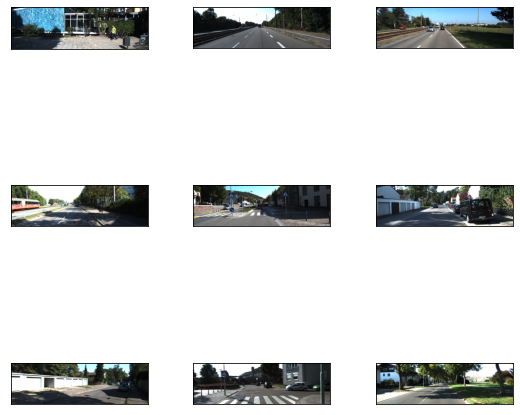

In [3]:
fig = tfds.show_examples(ds_train, ds_info)

데이터 다운로드 시 담아둔 ds_info에서는 불러온 데이터셋의 정보를 확인할 수 있습니다. 

- 오늘 사용할 데이터셋은 7,481개의 학습 데이터(training data)
- 711개의 평가용 데이터(test data)
- 423개의 검증용 데이터(validation data)로 구성되어 있습니다. 

라벨에는 alpha, bbox, dimensions, location, occluded, rotation_y, truncated 등의 정보가 있습니다.

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

# 자율주행 보조장치 (2) 데이터 직접 확인하기
이번에는 데이터셋을 직접 확인하는 시간을 갖도록 하겠습니다. ds_train.take(1)을 통해서 데이터셋을 하나씩 뽑아볼 수 있는 TakeDataset을 얻을 수 있습니다. 이렇게 뽑은 데이터에는 image 등의 정보가 포함되어 있습니다.

눈으로 확인해서 학습에 사용할 데이터를 직접 이해해 봅시다.

In [5]:
TakeDataset = ds_train.take(1)

--Example--
['image', 'image/file_name', 'objects']
--objects--
{'alpha': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([-1.57,  2.27,  1.29,  1.69,  1.73], dtype=float32)>, 'bbox': <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0.46018666, 0.47221416, 0.5290933 , 0.49326086],
       [0.34010667, 0.        , 0.6696    , 0.2144686 ],
       [0.28189334, 0.6333897 , 0.6157867 , 0.6786876 ],
       [0.46701333, 0.3852657 , 0.5223467 , 0.4065459 ],
       [0.46706668, 0.36178744, 0.52984   , 0.3841385 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[ 1.65,  1.67,  3.64],
       [ 3.59,  2.69, 35.24],
       [ 1.85,  0.37,  1.66],
       [ 1.67,  1.72,  4.02],
       [ 2.14,  1.94,  4.1 ]], dtype=float32)>, 'location': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[ -0.73,   1.92,  48.37],
       [-19.1 ,   2.18,  20.87],
       [  3.2 ,   1.44,  11.52],
       [ -9.93,   2.21,  60.69],
       [-13.86,   2.49,  68.26]], dtype=

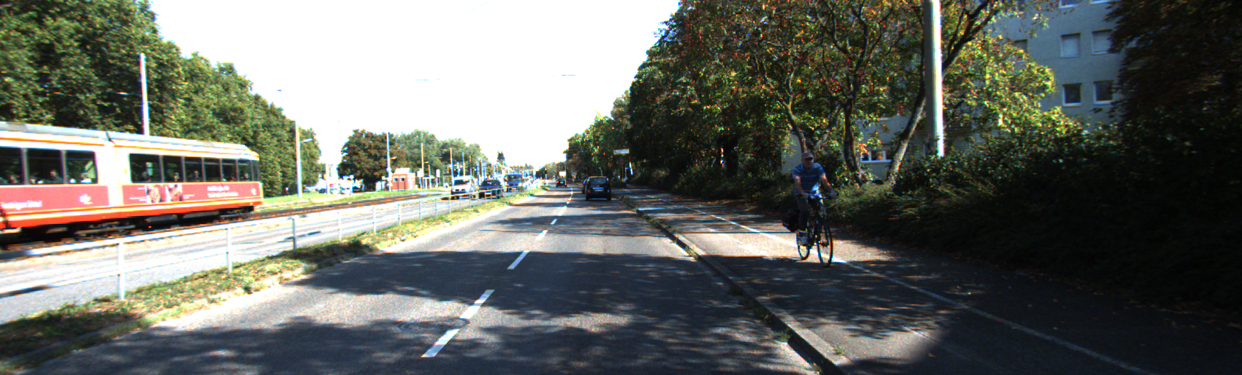

In [6]:
for example in TakeDataset:  
    print('--Example--')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('--objects--')
print(objects)
img = Image.fromarray(image.numpy())
img

이미지와 라벨을 얻는 방법을 알게 되었습니다. 그렇다면 이렇게 얻은 이미지의 바운딩 박스(bounding box, bbox)를 확인하기 위해서는 어떻게 해야 할까요?

아래는 KITTI에서 제공하는 데이터셋에 대한 설명입니다.

~~~
데이터셋 이해를 위한 예시
Values    Name      Description
----------------------------------------------------------------------------
   1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                     'Misc' or 'DontCare'
   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
                     truncated refers to the object leaving image boundaries
   1    occluded     Integer (0,1,2,3) indicating occlusion state:
                     0 = fully visible, 1 = partly occluded
                     2 = largely occluded, 3 = unknown
   1    alpha        Observation angle of object, ranging [-pi..pi]
   4    bbox         2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates
   3    dimensions   3D object dimensions: height, width, length (in meters)
   3    location     3D object location x,y,z in camera coordinates (in meters)
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
   1    score        Only for results: Float, indicating confidence in
                     detection, needed for p/r curves, higher is better.
~~~

위 설명과 예시 이미지를 참고하셔서 이미지 위에 바운딩 박스를 그려서 시각화해 보세요!

1 1242 375
2 (5, 4)
3 [[586.49     202.43001  612.63     176.59    ]
 [  0.       247.45999  266.37     123.899994]
 [786.67004  269.28998  842.93     144.08    ]
 [478.5      199.87     504.93002  179.12    ]
 [449.34     199.84999  477.1      176.31    ]]
4 [586.49    202.43001 612.63    176.59   ]
4 [  0.       247.45999  266.37     123.899994]
4 [786.67004 269.28998 842.93    144.08   ]
4 [478.5     199.87    504.93002 179.12   ]
4 [449.34    199.84999 477.1     176.31   ]
5 <PIL.Image.Image image mode=RGB size=1242x375 at 0x7F3068332D10>


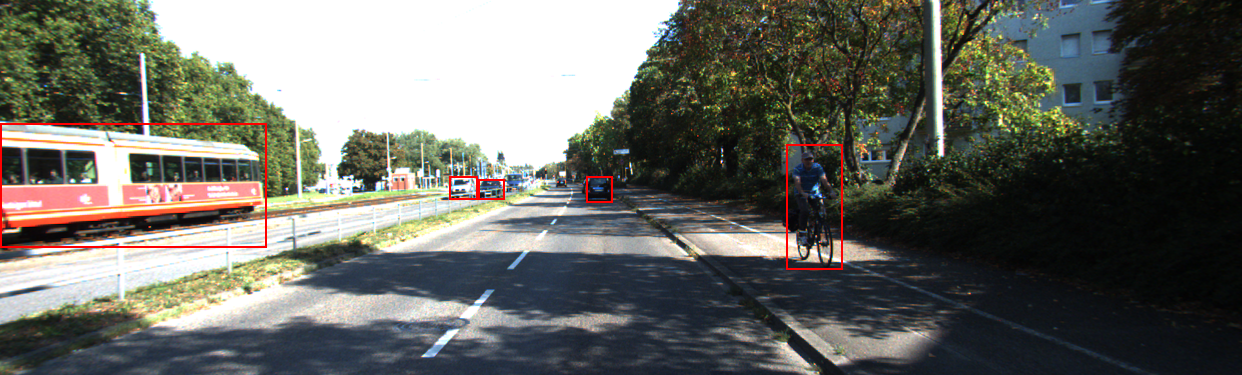

In [20]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

        # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print("1", width, height)
    print("2", object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

        # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    print("3", rects)
    for _rect in rects:
        print("4", _rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print("5", input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

# RetinaNet

RetinaNet은 Focal Loss for Dense Object Detection 논문을 통해 공개된 detection 모델입니다. Detection 모델을 직접 만들기에는 많은 시간이 소요되기 때문에, 미리 모델을 구현한 라이브러리를 가져와 커스텀 데이터셋에 학습시키고 빠르게 사용해 보겠습니다.

1-stage detector 모델인 YOLO와 SSD는 2-stage detector인 Faster-RCNN 등보다 속도는 빠르지만 성능이 낮은 문제를 가지고 있었습니다. 이를 해결하기 위해서 RetinaNet에서는 focal loss와 FPN(Feature Pyramid Network) 를 적용한 네트워크를 사용합니다.

## Focal Loss
Focal loss는 기존의 1-stage detection 모델들(YOLO, SSD)이 물체 전경과 배경을 담고 있는 모든 그리드(grid)에 대해 한 번에 학습됨으로 인해서 생기는 클래스 간의 불균형을 해결하고자 도입되었습니다. 

## FPN(Feature Pyramid Network)
FPN은 특성을 피라미드처럼 쌓아서 사용하는 방식입니다. CNN 백본 네트워크에서는 다양한 레이어의 결과값을 특성맵으로 사용할 수 있습니다. 이때 컨볼루션 연산은 커널을 통해 일정한 영역을 보고 몇 개의 숫자로 요약해 내기 때문에, 입력 이미지를 기준으로 생각하면 입력 이미지와 먼 모델의 뒷쪽의 특성 맵일수록 하나의 "셀(cell)"이 넓은 이미지 영역의 정보를 담고 있고, 입력 이미지와 가까운 앞쪽 레이어의 특성 맵일수록 좁은 범위의 정보를 담고 있습니다. 이를 receptive field라고 합니다. 레이어가 깊어질 수록 pooling을 거쳐 넓은 범위의 정보(receptive field)를 갖게 되는 것입니다.

FPN은 백본의 여러 레이어를 한꺼번에 쓰겠다라는데에 의의가 있습니다. SSD가 각 레이어의 특성 맵에서 다양한 크기에 대한 결과를 얻는 방식을 취했다면 RetinaNet에서는 receptive field가 넓은 뒷쪽의 특성 맵을 upsampling(확대)하여 앞단의 특성 맵과 더해서 사용했습니다. 레이어가 깊어질수록 feature map의 w,h방향의 receptive field가 넓어지는 것인데, 넓게 보는 것과 좁게 보는 것을 같이 쓰겠다는 목적인 거죠.

# keras-retinanet 실습 (1) 데이터 포맷 변경

Keras RetinaNet은 케라스(Keras) 라이브러리로 구현된 RetinaNet입니다. 현재는 텐서플로우 2 버전을 지원하는 리포지토리(repository)도 만들어졌으나 아직 커스텀 데이터셋을 학습하는 방법을 공식 문서로 제시하지 않고 있습니다. 지금은 우선 Keras RetineNet 리포지토리를 이용해보도록 하겠습니다.

우리가 가진 tensorflow_dataset의 데이터셋을 그대로 사용해서 Keras RetinaNet을 학습시키기 위해서는 라이브러리를 수정해야 합니다. 하지만 이보다 더 쉬운 방법은 해당 모델을 훈련할 수 있는 공통된 데이터셋 포맷인 CSV 형태로 모델을 변경해주는 방법입니다.

# 클래스 및 바운딩 박스 정보 추출

우리는 tensorflow_dataset의 API를 사용해 이미지와 각 이미지에 해당하는 바운딩 박스 라벨의 정보를 얻을 수 있었습니다. 그렇다면 API를 활용하여 데이터를 추출, 이를 포맷팅 하여 CSV 형태로 한 줄씩 저장해 봅시다.

한 라인에 이미지 파일의 위치, 바운딩 박스 위치, 그리고 클래스 정보를 가지는 CSV 파일을 작성하도록 코드를 작성하고, 이를 사용해 CSV 파일을 생성해 주세요. 우리가 생각하는 브레이크 시스템은 차와 사람을 구분해야 하는 점을 유의하시기 바랍니다.

데이터셋 포맷은 아래를 참고해 주세요.

~~~
# 데이터셋 형식
path/to/image.jpg,x1,y1,x2,y2,class_name

# Example
/data/imgs/img_001.jpg,837,346,981,456,cow
/data/imgs/img_002.jpg,215,312,279,391,cat
/data/imgs/img_002.jpg,22,5,89,84,bird
/data/imgs/img_003.jpg,,,,,
~~~

CSV로 저장할 때는 아래 코드를 참고해 주세요.

~~~
# 데이터셋 저장 시 참고
df_test = parse_dataset(ds_test, total=ds_info.splits['test'].num_examples)
df_test.to_csv('./kitti_test.csv', sep=',',index = False, header=False)
~~~

In [8]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [10:08<00:00, 10.44it/s]


In [9]:
train_csv_path

'/home/aiffel0042/aiffel/object_detection/data/kitti_train.csv'

In [10]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:11<00:00,  9.91it/s]


In [11]:
test_csv_path

'/home/aiffel0042/aiffel/object_detection/data/kitti_test.csv'

# 클래스 맵핑
데이터셋에서 클래스는 문자열(string)으로 표시되지만, 모델에게 데이터를 알려줄 때에는 숫자를 사용해 클래스를 표시해야 합니다. 이때 모두 어떤 클래스가 있고 각 클래스가 어떤 인덱스(index)에 맵핑(mapping)될지 미리 정하고 저장해 두어야 학습을 한 후 추론(inference)을 할 때에도 숫자 인덱스로 나온 정보를 클래스 이름으로 바꾸어 해석할 수 있습니다.

아래 형식을 참고하여, 자동차와 사람을 구별하기 위한 클래스 맵핑 함수를 만들어 주세요.

~~~
class_name,id

#Example
cow,0
cat,1
bird,2
~~~


In [12]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

# keras-retinanet 실습 (2) 셋팅

먼저 터미널을 열어주세요. 미리 설치해 둔 케라스 및 Keras RetinaNet 리포지토리를 사용하겠습니다.

아직 설치하지 않으셨다면, 0번 스텝의 '준비물' 항목을 참고하여 환경을 셋팅해 주세요.

준비가 완료되었다면 아래 스크립트를 참고하셔서 위에서 변환한 데이터셋으로 학습을 시작해 주세요. 학습이 잘 되기 위해서는 환경에 따라 batch_size나 worker, epoch를 조절해야 합니다.

훈련 이미지 크기 또는 batch_size가 너무 크면 GPU에서 out-of-memory 에러가 날 수 있으니 적절히 조정해 주세요. 원 개발자는 8G 메모리도 RetinaNet을 훈련시키기에는 부족할 수 있다고 설명합니다

In [13]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv ~/aiffel/object_detection/data/kitti_train.csv ~/aiffel/object_detection/data/classes.txt

2020-11-03 10:24:32.181219: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-03 10:24:33.259300: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-03 10:24:33.291690: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-03 10:24:33.293292: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2020-11-03 10:24:33.293368: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-03 10:24:33.299341: I tensorflow/stream_executor/platform

Epoch 1/50
2020-11-03 10:24:41.430209: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2020-11-03 10:24:42.636328: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2020-11-03 10:24:42.660187: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2020-11-03 10:24:42.886607: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2020-11-03 10:24:54.940768: W tensorflow/core/common_runtime/bfc_allocator.cc:246] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
195/

195/195 [==============================] - ETA: 0s - loss: 1.5101 - regression_loss: 1.1736 - classification_loss: 0.3365
Epoch 00014: saving model to ./snapshots/resnet50_csv_14.h5

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
195/195 [==============================] - 59s 303ms/step - loss: 1.5101 - regression_loss: 1.1736 - classification_loss: 0.3365
Epoch 15/50
195/195 [==============================] - ETA: 0s - loss: 1.2589 - regression_loss: 0.9672 - classification_loss: 0.2917
Epoch 00015: saving model to ./snapshots/resnet50_csv_15.h5
195/195 [==============================] - 58s 298ms/step - loss: 1.2589 - regression_loss: 0.9672 - classification_loss: 0.2917
Epoch 16/50
195/195 [==============================] - ETA: 0s - loss: 1.1608 - regression_loss: 0.8999 - classification_loss: 0.2609
Epoch 00016: saving model to ./snapshots/resnet50_csv_16.h5
195/195 [==============================] - 57s 293ms/step - loss: 1.1608 - regression_loss:

195/195 [==============================] - ETA: 0s - loss: 1.1126 - regression_loss: 0.8587 - classification_loss: 0.2539
Epoch 00030: saving model to ./snapshots/resnet50_csv_30.h5

Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.99999943962493e-12.
195/195 [==============================] - 58s 296ms/step - loss: 1.1126 - regression_loss: 0.8587 - classification_loss: 0.2539
Epoch 31/50
195/195 [==============================] - ETA: 0s - loss: 1.0653 - regression_loss: 0.8168 - classification_loss: 0.2485
Epoch 00031: saving model to ./snapshots/resnet50_csv_31.h5
195/195 [==============================] - 56s 290ms/step - loss: 1.0653 - regression_loss: 0.8168 - classification_loss: 0.2485
Epoch 32/50
195/195 [==============================] - ETA: 0s - loss: 1.1132 - regression_loss: 0.8434 - classification_loss: 0.2698
Epoch 00032: saving model to ./snapshots/resnet50_csv_32.h5

Epoch 00032: ReduceLROnPlateau reducing learning rate to 9.999999092680235e-13.
195/195 [==

195/195 [==============================] - ETA: 0s - loss: 1.0518 - regression_loss: 0.8091 - classification_loss: 0.2427
Epoch 00046: saving model to ./snapshots/resnet50_csv_46.h5

Epoch 00046: ReduceLROnPlateau reducing learning rate to 9.999999010570977e-19.
195/195 [==============================] - 57s 295ms/step - loss: 1.0518 - regression_loss: 0.8091 - classification_loss: 0.2427
Epoch 47/50
195/195 [==============================] - ETA: 0s - loss: 1.0810 - regression_loss: 0.8189 - classification_loss: 0.2621
Epoch 00047: saving model to ./snapshots/resnet50_csv_47.h5
195/195 [==============================] - 59s 300ms/step - loss: 1.0810 - regression_loss: 0.8189 - classification_loss: 0.2621
Epoch 48/50
195/195 [==============================] - ETA: 0s - loss: 1.0603 - regression_loss: 0.8151 - classification_loss: 0.2451
Epoch 00048: saving model to ./snapshots/resnet50_csv_48.h5

Epoch 00048: ReduceLROnPlateau reducing learning rate to 9.999999424161285e-20.
195/195 [=

아래 코드를 사용해 학습된 모델을 추론을 위해 실행할 수 있는 케라스 모델로 변환합시다.

In [14]:
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/convert_model.py ./snapshots/resnet50_csv_50.h5 ./snapshots/resnet50_csv_50_infer.h5

2020-11-03 11:13:52.933724: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-03 11:13:54.196511: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-03 11:13:54.217957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-03 11:13:54.218284: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2020-11-03 11:13:54.218300: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-03 11:13:54.219527: I tensorflow/stream_executor/platform

# keras-retinanet 실습 (3) 시각화
이제 위에서 변환한 모델을 load하고 추론 및 시각화를 해보세요!

아래에 load된 모델을 통해 추론을 하고 시각화를 하는 함수를 작성해 주세요. 일정 점수 이하는 경우를 제거해야 함을 유의해 주세요.

아래에서 몇 가지 테스트 셋을 받아 사용해 보세요.

- \\$ mkdir -p ~/aiffel/object_detection/test_set
- \\$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/test_set.zip
- \\$ mv test_set.zip ~/aiffel/object_detection/test_set
- \\$ cd ~/aiffel/object_detection/test_set && unzip test_set.zip

In [15]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

model_path = os.path.join('.', 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


[594.29834 177.07045 626.73773 205.36682]
[196.68549 140.157   358.3167  230.01205]


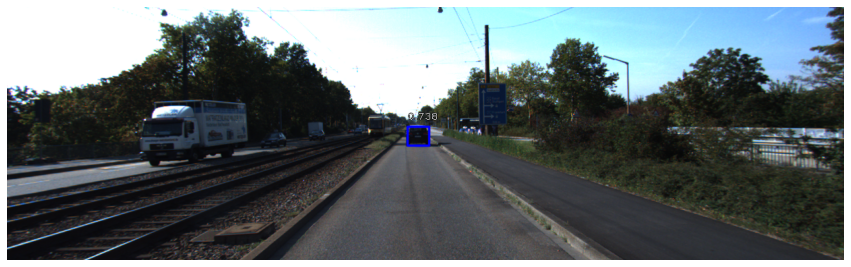

In [70]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path=img_path)

[770.7227  153.88544 842.2044  313.31744]
[773.5154  156.27327 847.4809  307.97437]


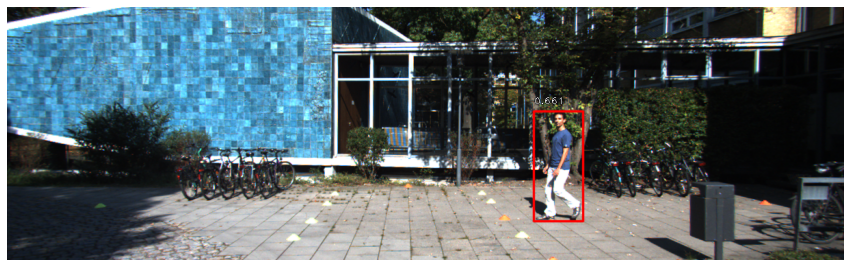

In [17]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path=img_path)

# 프로젝트: 자율주행 보조 시스템 만들기
## 1. 자율주행 시스템 만들기
위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

입력으로 이미지 경로를 받습니다.
정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
조건은 다음과 같습니다.
사람이 한 명 이상 있는 경우
차량의 크기(width or height)가 300px이상인 경우

In [94]:
def autonomous_driving_sytem(model, img_path, size_limit=300, visualize=True):
    image = read_image_bgr(img_path)
    
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    color_map = {
        0:(0,0,255),
        1:(255,0,0)
    }
    
    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    # correct for image scale
    boxes /= scale
    
    # display images
    if visualize:
        result = "Go"
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score<0.5:
                break
            b = box.astype(int)
                   
            if not boxes == []:
                box_height = b[2]-b[0]
                box_width = b[3]-b[1]
                print("box_height=", box_height, "box_width=", box_width)
            
                if label == 0 and (box_height >= size_limit or box_width >= size_limit):
                    result = "Stop"
                    print("result", result)
        
                elif label == 1:
                    result = "Stop"
                    print("result", result)

                else:
                    if result == "Stop":
                        result = "Stop"
                        print("result", result)
                    else:
                        result = "Go"
                        print("result", result)
            else:
                result = "Go"
                print("result", result)
                    
            draw_box(draw, b, color=color_map[label])
            
            caption = "{:3f}".format(score)
            draw_caption(draw, b, caption)
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.title(result, fontsize=20)
        plt.imshow(draw)
        plt.show()
    
        return result

[812.7594  146.06056 880.2192  177.64056]


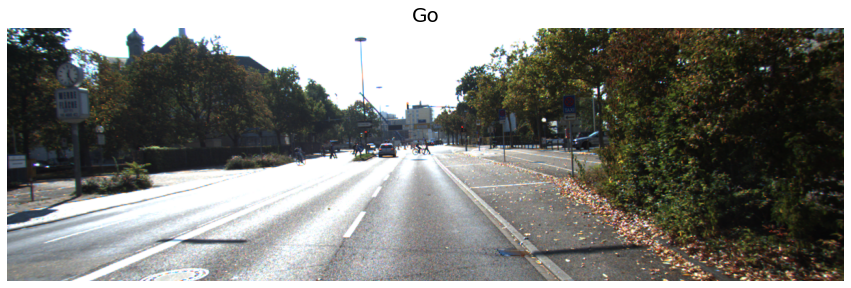

Go


In [95]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_3.png'
print(autonomous_driving_sytem(model=model,img_path=img_path))

# 2. 자율주행 시스템 평가하기
아래 test_system() 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.



In [96]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    win = 0
    total = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        print(image_path)
        result = autonomous_driving_sytem(model=model, img_path=image_path, visualize=True)
        total += 1
        if result == answer:
            score += 10
            win += 1
    print(f"총 {total}장 중에서 {win}개를 맞췄으므로, {score}점입니다.")

/home/aiffel0042/aiffel/object_detection/test_set/stop_1.png
[770.7227  153.88544 842.2044  313.31744]
box_height= 72 box_width= 160
result Stop
[773.5154  156.27327 847.4809  307.97437]


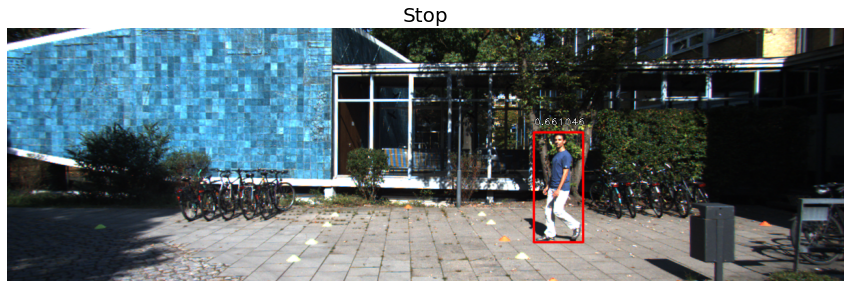

/home/aiffel0042/aiffel/object_detection/test_set/stop_2.png
[417.71805 163.49075 494.42856 331.34494]
box_height= 77 box_width= 168
result Stop
[415.43347 164.06395 496.42816 328.03638]


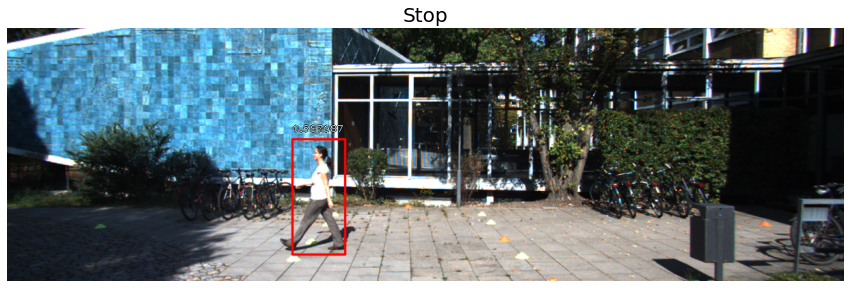

/home/aiffel0042/aiffel/object_detection/test_set/stop_3.png
[  0.      204.59293 311.60538 368.55698]
box_height= 311 box_width= 164
result Stop
[750.80115 158.74467 889.8143  212.25606]
box_height= 139 box_width= 54
result Stop
[787.6815  167.32007 879.2761  206.49608]


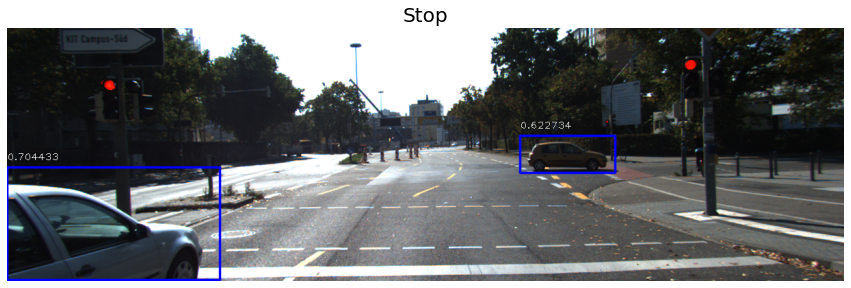

/home/aiffel0042/aiffel/object_detection/test_set/stop_4.png
[ 724.50073   39.91186 1110.2198   366.8234 ]
box_height= 386 box_width= 327
result Stop
[ 71.994316 159.9656   371.88297  310.25458 ]


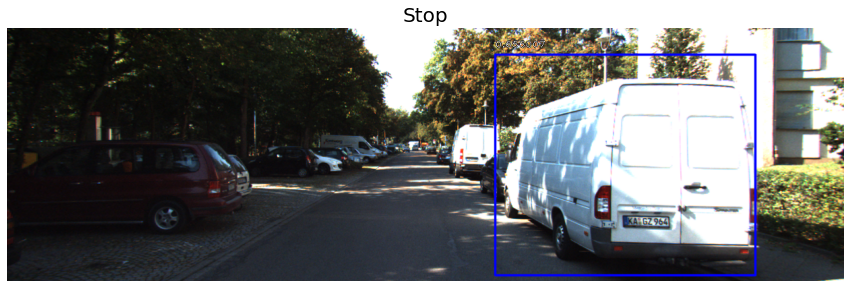

/home/aiffel0042/aiffel/object_detection/test_set/stop_5.png
[ 885.944    178.01799 1241.0684   372.6723 ]
box_height= 356 box_width= 194
result Stop
[733.297   164.2931  857.60187 246.41177]


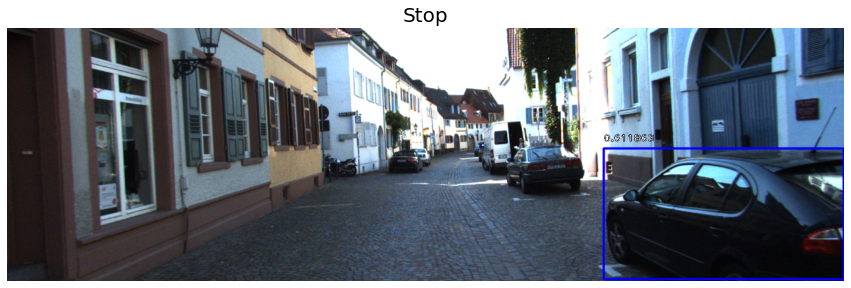

/home/aiffel0042/aiffel/object_detection/test_set/go_1.png
[594.29834 177.07045 626.73773 205.36682]
box_height= 32 box_width= 28
result Go
[196.68549 140.157   358.3167  230.01205]


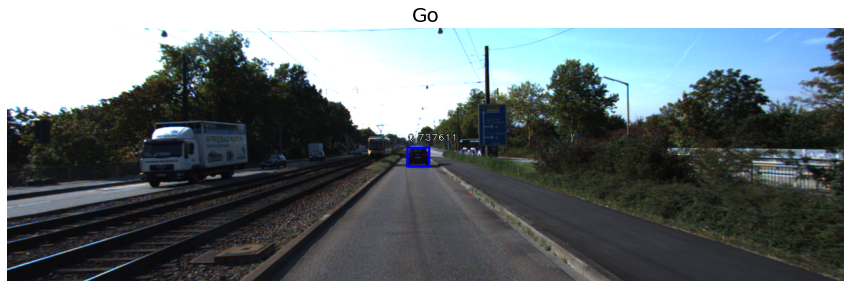

/home/aiffel0042/aiffel/object_detection/test_set/go_2.png
[627.81647 175.05133 668.27594 213.1147 ]
box_height= 41 box_width= 38
result Go
[514.92096 177.81387 569.35956 214.96632]


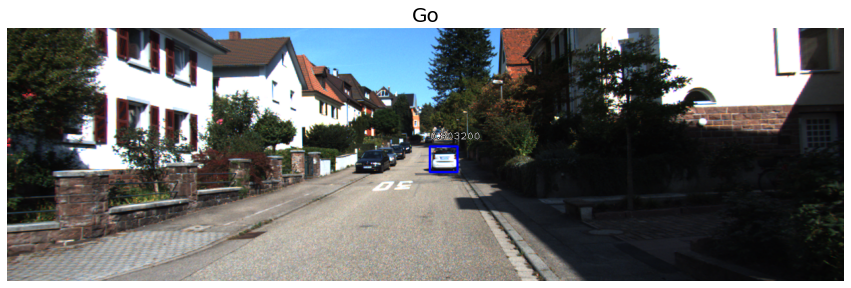

/home/aiffel0042/aiffel/object_detection/test_set/go_3.png
[812.7594  146.06056 880.2192  177.64056]


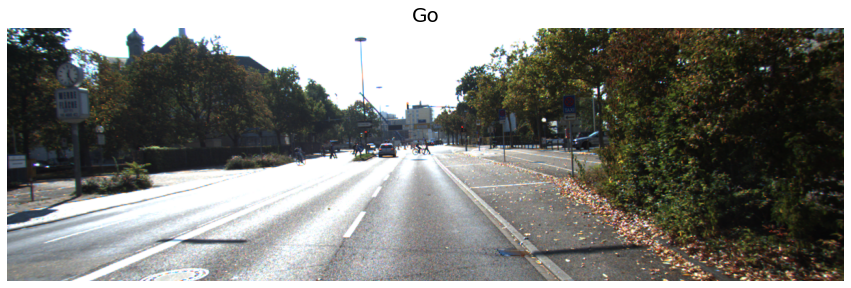

/home/aiffel0042/aiffel/object_detection/test_set/go_4.png
[693.50977 170.30275 788.2447  250.06186]


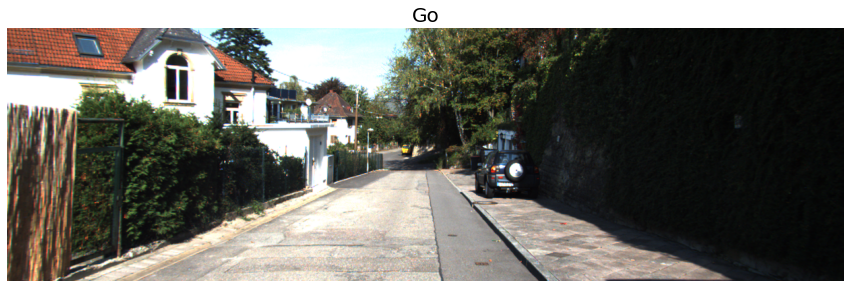

/home/aiffel0042/aiffel/object_detection/test_set/go_5.png
[  7.7713246 193.17812   195.60773   313.05957  ]


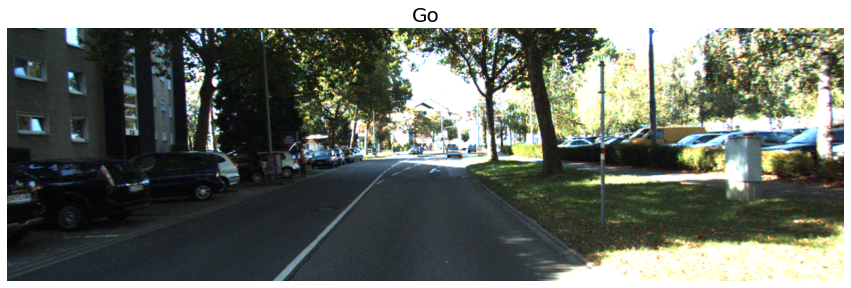

총 10장 중에서 10개를 맞췄으므로, 100점입니다.


In [97]:
test_system(autonomous_driving_sytem)

# 요약 정리

- 10장의 테스트 이미지에서 여러개의 bounding box가 있을 때 1명이라도 사람인면 바로 멈추고
- 차량이라면 크기가 가까이 있는지(300px) 여부에 따라서 진행(Go)과 멈춤(Stop)을 결과로 낼 수 있도록 코딩해 보았다. 
- 아직까지 차량이나, 사람에 대한 인식율도 떨어지고, 단순하게 차량의 크기 여부로 정지를 결정하지만
- 실제 사례에서는 주행방향과 속도에 맞춰서 바로 의사결정을 해야 하므로 훨씬 더 어려운 로직이 들어가야 할 것이라 생각된다. 